In [1]:

import pandas as pd
import numpy as np

from scipy import stats

import os 

os.chdir("/home/ptruong/git/dia_sum/scripts/PXD002952")

from q_value import qvalues
from triqler_output_to_df import  parse_triqler
os.chdir("/hdd_14T/data/PXD002952/osw_res_20210303/hye124/ttof6600/32fix/full_ts_v")

In [2]:

# filename has different formatting, we need to change number or implement regex.
experiment_id_mapper = lambda x: x.split("_")[5]
sample_id_mapper = lambda x: x.split("_")[8] #hye124 
specie_mapper = lambda x: x.split("_")[-1]

def read_in_and_filter(filename, m_score_treshold = 0.01):  
    print(filename)
    df = pd.read_csv(filename, sep = "\t")
    df = df[df.decoy != 1]
    df = df[df.m_score < m_score_treshold] # filter away crap, so all values should be good... we take average of top3 here
    print(str(len(df)) + " significantly identified peptides at " + str(m_score_treshold) + " FDR-treshold.")
    print("")
    df["experiment_id"] = df["filename"].map(experiment_id_mapper)
    df["sample_id"] = df["filename"].map(sample_id_mapper)
    sample_id = df.sample_id[0]
    experiment_id = df.experiment_id[0]     

    #midx = pd.MultiIndex(levels = [[sample_id],[experiment_id]], codes = [[0],[0]], names = ["sample_id", "experiment_id"])
    df["specie"] = df["ProteinName"].map(specie_mapper)
    df = df.set_index(["specie", "ProteinName", "FullPeptideName", "sample_id", "experiment_id"])
    df = df[["Intensity"]]
    df = pd.DataFrame(df.values, index = df.index)
    
    return df


In [3]:

dfs = []
for file in os.listdir():
    if file[-4:] == ".tsv":
        dfs.append(read_in_and_filter(file, m_score_treshold=0.01))
        #print(len(df_part))
        #df = pd.concat([df, df_part],axis = 1)        
df = pd.concat(dfs, axis = 0)
df = np.log2(df)

HYE124_TTOF6600_32fix_lgillet_I150211_005-Pedro_-_Sample_2_-_SW32_-_Repl2.mzML.tsv
33070 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_006-Pedro_-_Sample_1_-_SW32_-_Repl3.mzML.tsv
31895 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_003-Pedro_-_Sample_2_-_SW32_-_Repl1.mzML.tsv
32521 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_004-Pedro_-_Sample_1_-_SW32_-_Repl2.mzML.tsv
31588 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_007-Pedro_-_Sample_2_-_SW32_-_Repl3.mzML.tsv
33516 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_002-Pedro_-_Sample_1_-_SW32_-_Repl1.mzML.tsv
31707 significantly identified peptides at 0.01 FDR-treshold.



In [4]:
x = len(df[df.index.get_level_values("sample_id") == "1"].index.get_level_values("FullPeptideName").unique())
x_paper = 34851
print(f"Iteration 1 has {x} peptides identified.")
print(f"Reported iteration 1 is {x_paper} peptides identifies. ")
print(f"Diff {x_paper - x} ({(x_paper/x - 1)})")

Iteration 1 has 32214 peptides identified.
Reported iteration 1 is 34851 peptides identifies. 
Diff 2637 (0.0818588191469547)


In [5]:
x = len(df[df.index.get_level_values("sample_id") == "2"].index.get_level_values("FullPeptideName").unique())
x_paper = 35110
print(f"Iteration 2 has {x} peptides identified.")
print(f"Reported iteration 2 is {x_paper} peptides identifies. ")
print(f"Diff {x_paper - x} ({(x_paper/x - 1)})")

Iteration 2 has 33628 peptides identified.
Reported iteration 2 is 35110 peptides identifies. 
Diff 1482 (0.044070417509218585)


In [6]:

import matplotlib.pyplot as plt
import seaborn as sns 

def get_peptide_mu_sigma(df):
    df_means = df.groupby(df.index.get_level_values("FullPeptideName")).mean()
    
    df_stat = pd.DataFrame(df_means.values, index = df_means.index, columns = ["mu"])
    df_stat["std"] = df.groupby(df.index.get_level_values("FullPeptideName")).std()
    df_stat["std/mu-ratio"] = df_stat["std"] / df_stat["mu"]
    return df_stat

def select_specie_and_sample(df, specie = "HUMAN", sample = "1"):
    return df.iloc[(df.index.get_level_values("specie") == specie) & (df.index.get_level_values("sample_id") == sample), :]

def select_sample(df, sample = "1"):
    return df.iloc[(df.index.get_level_values("sample_id") == sample), :]

In [7]:
mu_sig_sample1 = get_peptide_mu_sigma(select_sample(df, sample = "1"))
mu_sig_sample2 = get_peptide_mu_sigma(select_sample(df, sample = "2"))

bins = [i*2 for i in range(11)]
mu_sig_sample1["binned_mu"] = pd.cut(mu_sig_sample1["mu"], bins)
mu_sig_sample1["quantile_bin_mu"] = pd.qcut(mu_sig_sample1["mu"], q=8)

mu_sig_sample2["binned_mu"] = pd.cut(mu_sig_sample2["mu"], bins)
mu_sig_sample2["quantile_bin_mu"] = pd.qcut(mu_sig_sample2["mu"], q=8)

In [9]:
mu_sig_sample1

,mu,std,std/mu-ratio,binned_mu,quantile_bin_mu
FullPeptideName,,,,,
AAAAAAAAAPAAAATAPTTAATTAATAAQ,10.159758,0.178626,0.017582,"(10, 12]","(9.947, 16.493]"
AAAAAAALQAK,12.026917,0.241666,0.020094,"(12, 14]","(9.947, 16.493]"
AAAALAGGKK,5.065456,0.263487,0.052016,"(4, 6]","(1.8760000000000001, 6.309]"
AAADALSDLEIK,11.829895,0.159259,0.013462,"(10, 12]","(9.947, 16.493]"
AAADALSDLEIKDSK,11.587043,1.340377,0.115679,"(10, 12]","(9.947, 16.493]"
...,...,...,...,...,...
YYTPTISR,9.849121,0.114110,0.011586,"(8, 10]","(9.097, 9.947]"
YYTSASGDEMVSLK,9.850609,0.116020,0.011778,"(8, 10]","(9.097, 9.947]"
YYTSASGDEMVSLKDYC(UniMod:4)TR,8.387776,0.060175,0.007174,"(8, 10]","(8.061, 8.527]"


Text(0.5, 1.0, 'sample2 - std/mu vs quantile_bin_mu for log-transformed peptide values')

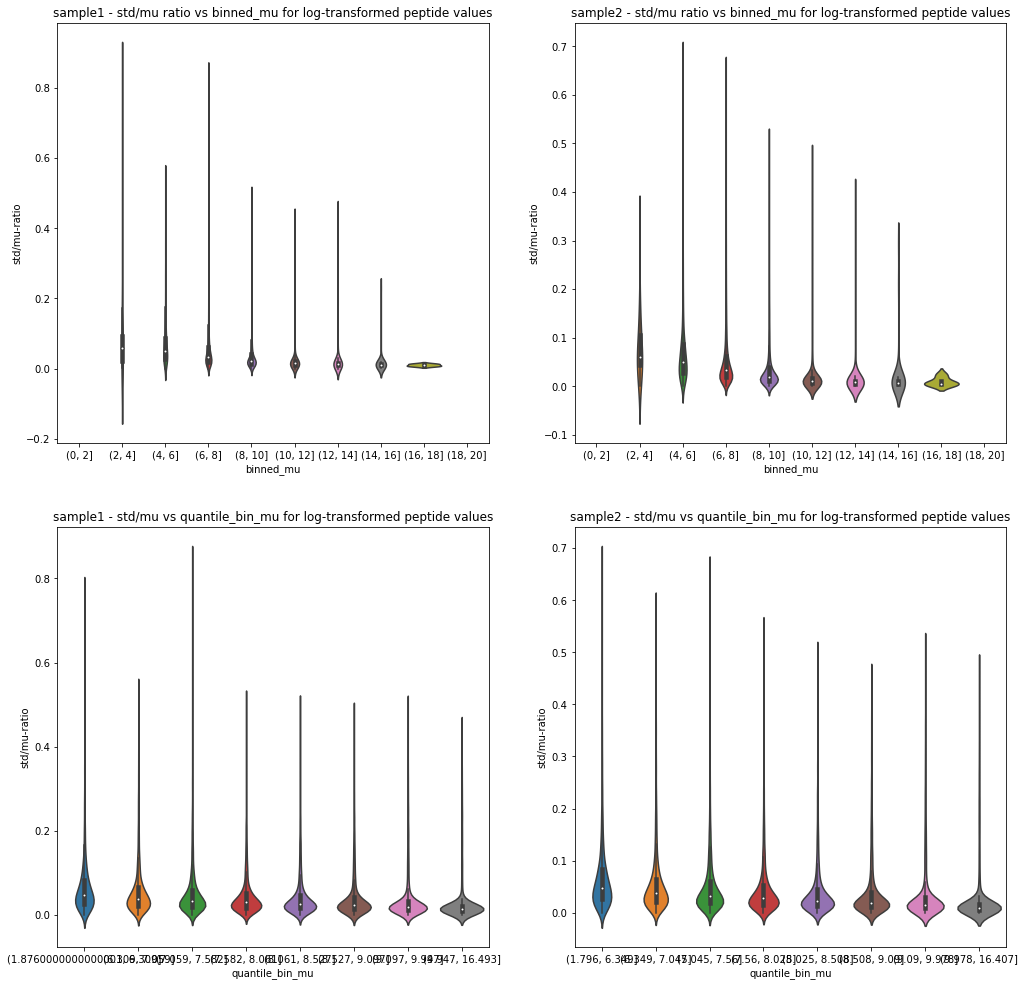

In [8]:
f, ax = plt.subplots(2, 2, figsize = (17,17))
sns.violinplot(x='binned_mu', y='std/mu-ratio', data=mu_sig_sample1, ax=ax[0,0])
ax[0,0].set_title("sample1 - std/mu ratio vs binned_mu for log-transformed peptide values")

sns.violinplot(x='binned_mu', y='std/mu-ratio', data=mu_sig_sample2, ax=ax[0,1])
ax[0,1].set_title("sample2 - std/mu ratio vs binned_mu for log-transformed peptide values")

sns.violinplot(x='quantile_bin_mu', y='std/mu-ratio', data=mu_sig_sample1, ax=ax[1,0])
ax[1,0].set_title("sample1 - std/mu vs quantile_bin_mu for log-transformed peptide values")

sns.violinplot(x='quantile_bin_mu', y='std/mu-ratio', data=mu_sig_sample2, ax=ax[1,1])
ax[1,1].set_title("sample2 - std/mu vs quantile_bin_mu for log-transformed peptide values")
